In [193]:
import torch
import requests
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm

from torchvision import transforms
from PIL import Image
from yolov3.utils.loss import ComputeLoss
from yolov3.utils.datasets import LoadImagesAndLabels, letterbox
from yolov3.utils.general import non_max_suppression
from yolov3.utils.autoanchor import check_anchor_order
from yolov3.models.common import Detections
from yolov3.models.yolo import Detect

# 1. Load Model

In [150]:
wrapper_model = torch.hub.load('ultralytics/yolov3', 'yolov3')  # or yolov3-spp, yolov3-tiny, custom

Using cache found in /home/tobias/.cache/torch/hub/ultralytics_yolov3_master
YOLOv3 🚀 2022-1-9 torch 1.10.1+cu102 CPU

Fusing layers... 
Model Summary: 261 layers, 61922845 parameters, 0 gradients, 156.1 GFLOPs
Adding AutoShape... 


In [151]:
model = wrapper_model.model
detector = model.model[-1]
print(f"Number of anchors: {detector.na}")
print(f"Classes: {model.names}")

Number of anchors: 3
Classes: ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [4]:
img = 'https://ultralytics.com/images/zidane.jpg'  # or file, Path, PIL, OpenCV, numpy, list

# 2. Example Inference

In [5]:
results = wrapper_model(img)

/opt/anaconda3/envs/argos/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


In [6]:
results.pred

[tensor([[7.44802e+02, 4.06422e+01, 1.15092e+03, 7.13376e+02, 9.15598e-01, 0.00000e+00],
         [1.32336e+02, 1.96820e+02, 1.05565e+03, 7.12946e+02, 8.82330e-01, 0.00000e+00],
         [4.38334e+02, 4.36242e+02, 5.23089e+02, 7.14748e+02, 8.59376e-01, 2.70000e+01],
         [9.84859e+02, 3.23786e+02, 1.02442e+03, 4.19271e+02, 4.76398e-01, 2.70000e+01],
         [9.85212e+02, 2.98472e+02, 1.12622e+03, 7.06462e+02, 3.51572e-01, 2.70000e+01]])]

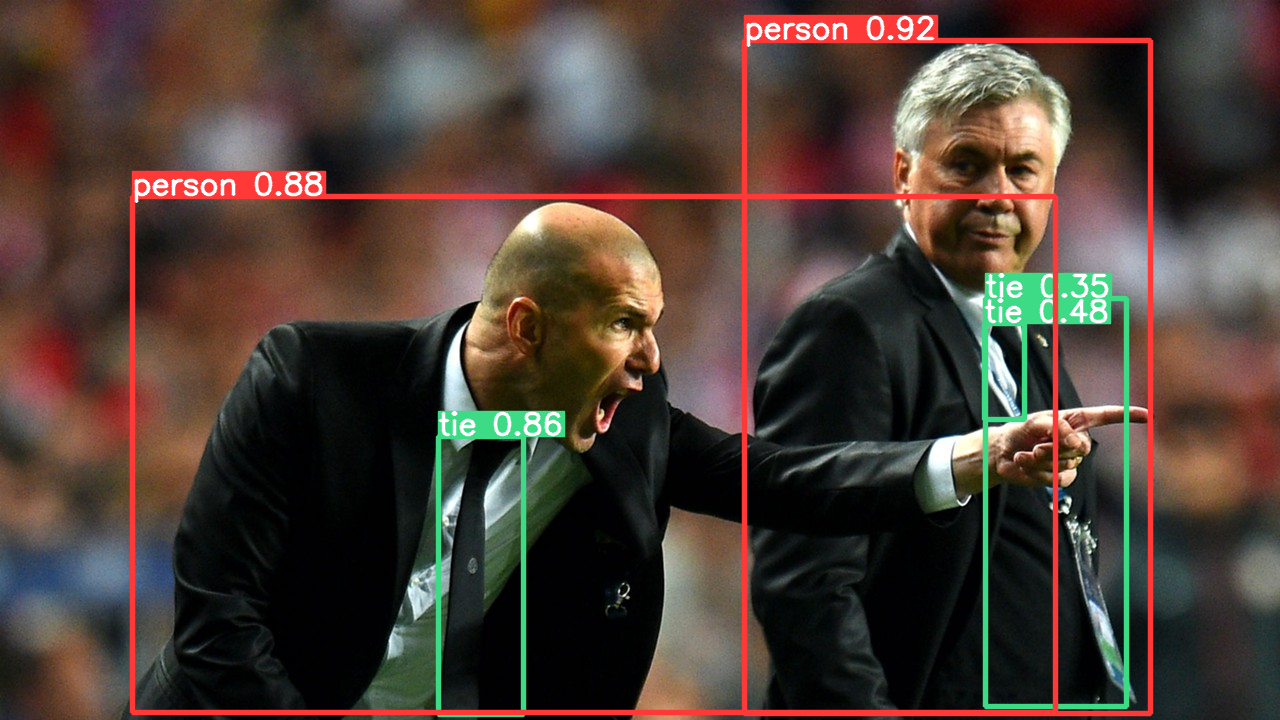

In [7]:
results.show()

# 3. Train

In [250]:
n_layers_unfreeze = 1 # Unfreeze last n layers
reset_parameters = True
n_cards = 7

In [251]:
argos_anchors = detector.anchors.clone().detach().view(detector.nl, -1)
argos_channels = [l.in_channels for l in detector.m]
argos_detector = Detect(nc=n_cards, anchors=argos_anchors, ch=argos_channels)

# parse_model():294 assigns some weird object attributes that we copy here
weird_bs = {'i', 'f', 'type', 'np'}
for bs in weird_bs:
    weird_attr = getattr(detector, bs)
    setattr(argos_detector, bs, weird_attr)
    
# Set some additional module attributes
argos_detector.stride = detector.stride
check_anchor_order(argos_detector)

print(f"Anchors: {argos_anchors}")
print(f"Channels: {argos_channels}")

Anchors: tensor([[ 1.25000,  1.62500,  2.00000,  3.75000,  4.12500,  2.87500],
        [ 1.87500,  3.81250,  3.87500,  2.81250,  3.68750,  7.43750],
        [ 3.62500,  2.81250,  4.87500,  6.18750, 11.65625, 10.18750]])
Channels: [256, 512, 1024]


In [252]:
def initialize_weights(model):
    for m in model.modules():
        t = type(m)
        if t is nn.Conv2d:
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        elif t is nn.BatchNorm2d:
            m.eps = 1e-3
            m.momentum = 0.03
        elif t in [nn.Hardswish, nn.LeakyReLU, nn.ReLU, nn.ReLU6, nn.SiLU]:
            m.inplace = True

In [253]:
model = model.train()
for param in model.parameters():
    param.requires_grad = False
    
model.model[-1] = argos_detector
model._initialize_biases()  # only run once
    
for idx_layer in range(n_layers_unfreeze):
    layer = model.model[-idx_layer - 1]
    for param in layer.parameters():
        param.requires_grad = True
        
    if reset_parameters:
        initialize_weights(layer)

loss_calculator = ComputeLoss(model)

In [254]:
print(f"Trainable parameters: {sum([p.numel() for p in model.parameters() if p.requires_grad])}")

Trainable parameters: 64620


In [255]:
model.hyp

{'lr0': 0.01,
 'lrf': 0.1,
 'momentum': 0.937,
 'weight_decay': 0.0005,
 'warmup_epochs': 3.0,
 'warmup_momentum': 0.8,
 'warmup_bias_lr': 0.1,
 'box': 0.05,
 'cls': 0.3,
 'cls_pw': 1.0,
 'obj': 0.7,
 'obj_pw': 1.0,
 'iou_t': 0.2,
 'anchor_t': 4.0,
 'fl_gamma': 0.0,
 'hsv_h': 0.015,
 'hsv_s': 0.7,
 'hsv_v': 0.4,
 'degrees': 0.0,
 'translate': 0.1,
 'scale': 0.9,
 'shear': 0.0,
 'perspective': 0.0,
 'flipud': 0.0,
 'fliplr': 0.5,
 'mosaic': 1.0,
 'mixup': 0.1,
 'copy_paste': 0.0,
 'label_smoothing': 0.0}

In [256]:
optimizer = Adam(model.parameters(), lr=3e-4, betas=(model.hyp['momentum'], 0.999))

In [257]:
# target [n_classes, 6]

# image,class,x,y,w,h

# cls
# x center
# y center
# width
# height

In [258]:
# Detect class 2 everywhere
targets = [
    [0, 2, 0.5, 0.5, 0.1, 0.1],
]
targets = torch.tensor(targets)

In [259]:
pil_img = Image.open(requests.get(img, stream=True).raw)
img_numpy = np.asarray(pil_img)

imgs = [img_numpy]
x = [letterbox(im, auto=False)[0] for im in imgs]  # pad
x = np.stack(x, 0) if len(imgs) > 1 else x[0][None]  # stack
x = np.ascontiguousarray(x.transpose((0, 3, 1, 2)))  # BHWC to BCHW
x = torch.from_numpy(x)

In [260]:
x.shape

torch.Size([1, 3, 640, 640])

In [277]:
model = model.train()
for _ in range(10):
    output = model(x.type_as(next(model.parameters())))
    loss, loss_items = loss_calculator(output, targets)
    print(f"Loss: {loss.item():0.4f}")
    loss.backward()
    optimizer.step()

Loss: 2.6978
Loss: 2.6413
Loss: 2.5861
Loss: 2.5323
Loss: 2.4797
Loss: 2.4288
Loss: 2.3793
Loss: 2.3309
Loss: 2.2837
Loss: 2.2375


In [271]:
output[0].shape

torch.Size([1, 3, 80, 80, 12])

In [272]:
output[2][0][:,:,:,10].mean()

tensor(-8.93488, grad_fn=<MeanBackward0>)

In [273]:
wrapper_model = wrapper_model.eval()
inference_result = wrapper_model(img)

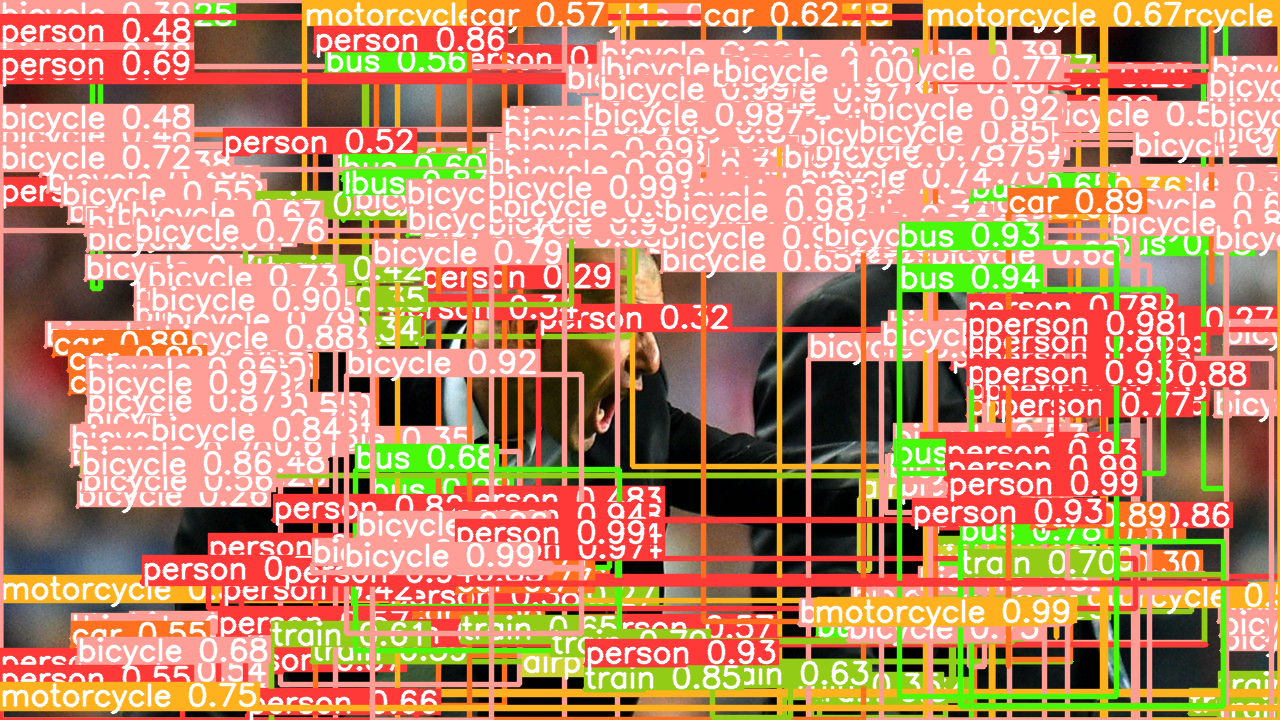

In [274]:
inference_result.show()

In [ ]:
nms = non_max_suppression(output[0], wrapper_model.conf, iou_thres=wrapper_model.iou, classes=wrapper_model.classes, multi_label=wrapper_model.multi_label, max_det=wrapper_model.max_det)
detections = Detections(imgs, nms, [img, img], [1 for _ in range(100)], model.names, output[0].shape)
detections.show()